In [1]:
"""
Remaking plots of 
"""
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
np.random.seed(1337)

from tensorflow.keras.models import Sequential, load_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as stats
from scipy.stats import spearmanr, linregress


def relevant_metrics(y_pred, y_true):
    #returns the metrics for the dataframe to save for model performance 
    #sklearn r2 is not the linear coefficent 
    #using the scpy linregress function to get that r2
    res = linregress(y_pred, y_true)
    return mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred), res.rvalue**2, spearmanr(y_true, y_pred)[0]

In [2]:
# Plot predictions of best performing model of all data

all_doses_trial_num = 6

parsed_L3_cleaved_output_dir = "/JTE-607/Analysis/parsed_L3_input_RNA_clusterPASRandom_bbmerge_xloose/parsed_L3_cleaved_RNA_multimapping_mincov1_preload_bbmerge_xloose_H1shortN4indel/collapsed/"
output_models_dir = parsed_L3_cleaved_output_dir + "models_25nt_logratio_mixedsort_4120_batchnorm-07_25_2022-6epoch_x10/"
output_data_dir = parsed_L3_cleaved_output_dir + "models_25nt_logratio_mixedsort_4120_batchnorm-07_25_2022-6epoch_x10/data_splits/"

model = load_model("%s/JTE607_CNN_25nt_6epoch_4col_model_%s.hdf5" % (output_models_dir, all_doses_trial_num))
output_path_prefix = output_models_dir + "/JTE607_CNN_softmax_25nt_6epoch_4col_model_%s" % (all_doses_trial_num)

data_train_x = pickle.load(open(output_data_dir + "seq_e_train.p", "rb"))
data_train_y = pickle.load(open(output_data_dir + "res_train.p", "rb"))
data_test_x = pickle.load(open(output_data_dir + "seq_e_test.p", "rb"))
data_test_y = pickle.load(open(output_data_dir + "res_test.p", "rb"))

plt.rcParams["figure.figsize"] = (3.5,2.5)

[2022-08-25 22:42:43.682 ip-172-31-11-19.us-west-1.compute.internal:29356 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-25 22:42:43.703 ip-172-31-11-19.us-west-1.compute.internal:29356 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


[[ 0.05246857  0.33842617  0.45262122]
 [-0.00566706  0.04447675  0.1327773 ]
 [-0.00966852 -0.05015965 -0.01351172]
 ...
 [-0.1779452  -0.2065542  -0.27714473]
 [-0.04180186 -0.20153672 -0.46421242]
 [ 0.11224364  0.22894084  0.3744993 ]]
        0p5uM_percent  2p5uM_percent  12p5uM_percent
163138       0.194636       0.493411        0.408372
116379       0.002223      -0.213453       -0.070811
214442      -0.586912       0.183533       -0.068792
120683      -0.339278      -0.865778       -1.166084
142218      -0.000476       0.151943        0.312200
...               ...            ...             ...
220351      -0.283339      -0.264451       -0.221977
13568        0.119413       0.101932       -0.325597
234356      -0.613580      -0.891945       -0.849471
192725       0.053154      -0.191679       -0.251682
7343         0.250685       0.312220        0.633126

[257196 rows x 3 columns]


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


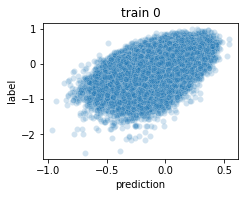

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


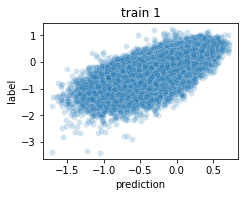

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


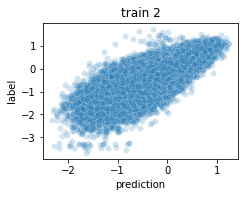

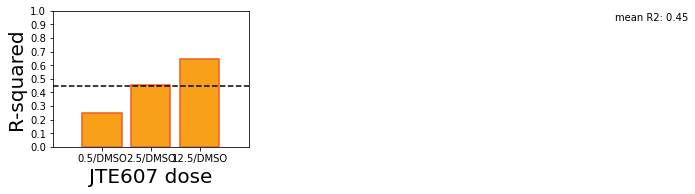

scores [0.252, 0.455, 0.643]


In [3]:
#evaluate on data 

#predict train, val, test sets 
x_preds = model.predict(data_train_x)
print(x_preds)
print(data_train_y)

scores = []
for i in range(3):
    pred = x_preds[:,i]
    obs = data_train_y[data_train_y.columns[i]]
    slope, intercept, r_value, p_value, std_err = linregress(obs,pred)
    scores.append(round(r_value**2, 3))
    
    sns.scatterplot(pred, obs, alpha = 0.2)
    plt.xlabel('prediction')
    plt.ylabel('label')
    plt.title('train %s' % (i))
    plt.savefig(output_path_prefix+"_scatter_train_%s.pdf" % (i))
    plt.show()
    relevant_metrics(pred, obs)

mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5/DMSO", "2.5/DMSO", "12.5/DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20)
plt.savefig(output_path_prefix+"_train_scatter.pdf")
plt.show()

print("scores", scores)


[[ 0.07393317  0.23711953  0.448493  ]
 [ 0.04024444  0.12116858  0.25887075]
 [-0.08447075 -0.04712914 -0.1188629 ]
 ...
 [ 0.00886097  0.01803149 -0.01399063]
 [-0.02262013 -0.00993222 -0.08441459]
 [ 0.04587201  0.0272915   0.06518573]]
      0p5uM_percent  2p5uM_percent  12p5uM_percent
0         -0.063896       0.214028        0.408453
1          0.158997       0.248974        0.382862
2         -0.169079       0.045483        0.017941
3         -0.011128      -0.358545       -0.694788
4         -0.263721      -0.588781       -1.410902
...             ...            ...             ...
4115       0.150214       0.271301        0.255428
4116       0.246171       0.039082        0.182652
4117       0.197842      -0.585476       -0.479392
4118       0.216018       0.100957        0.070861
4119       0.197842       0.014581        0.064910

[4120 rows x 3 columns]


/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


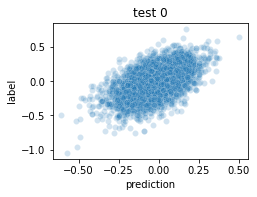

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


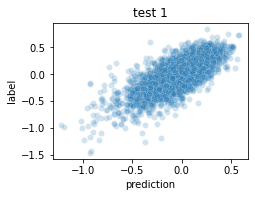

/home/ec2-user/anaconda3/envs/tensorflow2_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


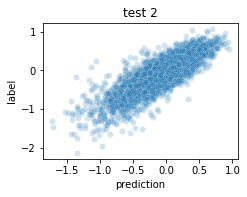

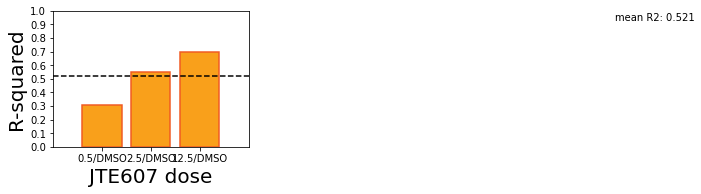

scores [0.311, 0.552, 0.7]


In [4]:
#evaluate on data 
#predict train, val, test sets 
x_preds = model.predict(data_test_x)
print(x_preds)
print(data_test_y)

scores = []
for i in range(3):
    pred = x_preds[:,i]
    obs = data_test_y[data_test_y.columns[i]]
    slope, intercept, r_value, p_value, std_err = linregress(obs,pred)
    scores.append(round(r_value**2, 3))
    
    sns.scatterplot(pred, obs, alpha = 0.2)
    plt.xlabel('prediction')
    plt.ylabel('label')
    plt.title('test %s' % (i))
    plt.savefig(output_path_prefix+"_scatter_test_%s.pdf" % (i))
    plt.show()
    relevant_metrics(pred, obs)

mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()
ax.bar(x=["0.5/DMSO", "2.5/DMSO", "12.5/DMSO"],height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,3));
ax.set_xlim((-1,3))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('JTE607 dose', size=20)
ax.set_ylabel('R-squared', size=20)
plt.savefig(output_path_prefix+"_test_scatter.pdf")
plt.show()

print("scores", scores)
